In [1]:
## Load all the dependencies
import os
import sys
import random
import warnings
import numpy as npjjjjjjjjj
from itertools import chain
from numpy import genfromtxt
from tensorflow import random
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, UpSampling2D, GlobalAveragePooling2D, Multiply, Dense, Reshape, Permute, multiply, dot, add, Input
from keras.layers.core import Dropout, Lambda, SpatialDropout2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model, model_from_yaml, Sequential
import tensorflow as tf

np.random.seed(1337) # for reproducibility
random.set_seed(1337)
print(tf.__version__)

2.1.0


Using TensorFlow backend.


In [2]:
# Use dice coefficient function as the loss function 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

# Jacard coefficient
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# calculate loss value
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# calculate loss value
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def Residual_CNN_block(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    return conv

class multiplication(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,x_query,phi_g,x_value = inputs[0],inputs[1],inputs[2],inputs[3],inputs[4]
        h,w,c = int(x.shape[1]),int(x.shape[2]),int(x.shape[3])
        x_query = K.reshape(x_query, shape=(-1,h*w, self.inter_channel//4))
        phi_g = K.reshape(phi_g,shape=(-1,h*w,self.inter_channel//4))
        x_value = K.reshape(x_value,shape=(-1,h*w,c))
        scale = dot([K.permute_dimensions(phi_g,(0,2,1)), x_query], axes=(1, 2))
        soft_scale = Activation('softmax')(scale)
        scaled_value = dot([K.permute_dimensions(soft_scale,(0,2,1)),K.permute_dimensions(x_value,(0,2,1))],axes=(1, 2))
        scaled_value = K.reshape(scaled_value, shape=(-1,h,w,c))        
        customize_multi = self.k * scaled_value
        layero = add([customize_multi,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([layero,g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*3)
    def get_custom_objects():
        return {'multiplication': multiplication}

def attention_up_and_concatenate(inputs):
    g,x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel, (2,2), strides=[2, 2],padding='same')(g)
    x_query = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    x_value = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    inputs = [g,x,x_query,phi_g,x_value]
    concate = multiplication(inter_channel)(inputs)
    return concate

class multiplication2(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication2, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication2, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,rate = inputs[0],inputs[1],inputs[2]
        scaled_value = multiply([x, rate])
        att_x =  self.k * scaled_value
        att_x = add([att_x,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([att_x, g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*2)
    def get_custom_objects():
        return {'multiplication2': multiplication2}

def attention_up_and_concatenate2(inputs):
    g, x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel//2, (3,3), strides=[2, 2],padding='same')(g)
    g = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    theta_x = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format='channels_last')(f)
    rate = Activation('sigmoid')(psi_f)
    concate =  multiplication2()([g,x,rate])
    return concate

In [3]:
loaded_model = load_model('June21/model/model_augv_attention2.h5',custom_objects={'multiplication': multiplication,'multiplication2': multiplication2,'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef,})

# remove the last 2 layer using pop() function
loaded_model.layers.pop()
loaded_model.layers.pop()

for (index, layer) in enumerate(loaded_model.layers):
    if (index > len(loaded_model.layers)-5):
      print("Here")
      layer.trainable = True
    else:
      layer.trainable = False

# Create new model from the model using the input and output of the last layer (after poping last 2 layers)
model_without_last = Model(loaded_model.input,  loaded_model.layers[-1].output)

# See model structure
#model_without_last.summary()

Here
Here
Here
Here


In [4]:
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1

# 1 dimensional convolution and generate probabilities from Sigmoid function
conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1), name='conv2d_last')(model_without_last.output)
new_out = Activation('sigmoid', name='activation_last')(conv_final)

# Created new model with the newly added last two layers 
transfered_model = Model(inputs=model_without_last.input, outputs=new_out)

# New model structure
#transfered_model.summary()

# If want to train on the data **without** the NAIP, run the block below.

In [21]:
data_path = 'Covington_data/non-overlap/'

# read in training and validation data
X_train = np.load(data_path+'train_data.npy')
Y_train = np.load(data_path+'train_label.npy')
X_Validation = np.load(data_path+'vali_data.npy')
Y_Validation = np.load(data_path+'vali_label.npy')

# The dataset has 9 channels:
# 0. Curvature
# 1. Slope
# 2. Openness
# 3. DEM
# 4. TPI 21
# 5. Reflectance (LiDAR intensity)
# 6. Geomorphon
# 7. TPI 9
# 8. TPI 3
# but the model expects 8 channels
# So we exclude TPI_9 channel from the data set
X_train_new = X_train[:,:,:,(0,1,2,3,4,5,6,8)]
print(X_train_new.shape)

X_Validation_new = X_Validation[:,:,:,(0,1,2,3,4,5,6,8)]
print(X_Validation_new.shape)

(350, 224, 224, 8)
(400, 224, 224, 8)


# If want to train on the data **with** the NAIP, run the block below.

In [5]:
data_path = 'Covington_data/include_NAIP/'

# read in training and validation sample patches
X_train_new = np.load(data_path+'train_data.npy')
X_Validation_new = np.load(data_path+'vali_data.npy')
print(X_train_new.shape)
print(X_Validation_new.shape)

#Read training and validation labels
Y_Validation = np.load(data_path+'vali_label.npy')
Y_train = np.load(data_path+'train_label.npy')

#Cast both labales to float32
Y_Validation = Y_Validation.astype(np.float32)
Y_train = Y_train.astype(np.float32)

(600, 224, 224, 8)
(600, 224, 224, 8)


In [7]:
patch_size = 224
IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
# Number of feature channels 
INPUT_CHANNELS = 8
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
maxepoch = 100
# hyperparameters
# learning_rate = 0.0000359
learning_rate = 0.0001
patience = 20
aug = 'v'
transfered_model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience+10, verbose=0),
        ModelCheckpoint('model'+aug+'_attention2.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

In [8]:
ltranfer_learning_results = transfered_model.fit(X_train_new, Y_train, validation_data=(X_Validation_new,Y_Validation), batch_size=12, epochs=maxepoch, callbacks=callbacks)

Train on 600 samples, validate on 600 samples
Epoch 1/100
600/600 [==============================] - 17s 28ms/step - loss: -0.0774 - dice_coef: 0.0774 - accuracy: 0.2053 - val_loss: -0.0459 - val_dice_coef: 0.0459 - val_accuracy: 0.0209
Epoch 2/100
600/600 [==============================] - 12s 20ms/step - loss: -0.1170 - dice_coef: 0.1170 - accuracy: 0.6685 - val_loss: -0.0735 - val_dice_coef: 0.0735 - val_accuracy: 0.7852
Epoch 3/100
600/600 [==============================] - 12s 20ms/step - loss: -0.1613 - dice_coef: 0.1613 - accuracy: 0.9180 - val_loss: -0.0846 - val_dice_coef: 0.0846 - val_accuracy: 0.8733
Epoch 4/100
600/600 [==============================] - 12s 20ms/step - loss: -0.1780 - dice_coef: 0.1780 - accuracy: 0.9284 - val_loss: -0.0826 - val_dice_coef: 0.0826 - val_accuracy: 0.8723
Epoch 5/100
600/600 [==============================] - 12s 20ms/step - loss: -0.1919 - dice_coef: 0.1919 - accuracy: 0.9384 - val_loss: -0.0841 - val_dice_coef: 0.0841 - val_accuracy: 0.8735

In [8]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
root_path = ''
# save the trained model
model_yaml = transfered_model.to_yaml()
with open(root_path+"model_attention2_transfered_NAIP_"+timestr+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# save the weights
transfered_model.save(root_path+"model_attention2_transfered_NAIP_"+timestr+".h5")
# save the intermdediate results and training statistics
with open(root_path+"history_attention2_transfered_NAIP_"+timestr+".pickle", 'wb') as file_pi:
    pickle.dump(ltranfer_learning_results.history, file_pi, protocol=2)


# Progress 3/29/2021
**Progress:**  
- Finsihed experiments for 10-100 samples
- running experiments for 200,300,400,500 
    - finsihed 200, 500 for trainging from scratch
    - Still runnning transfer learning 300-500 

The prediction from all experiment doesn't suggest any trend so far. However, training from scratch yields higher performance.   

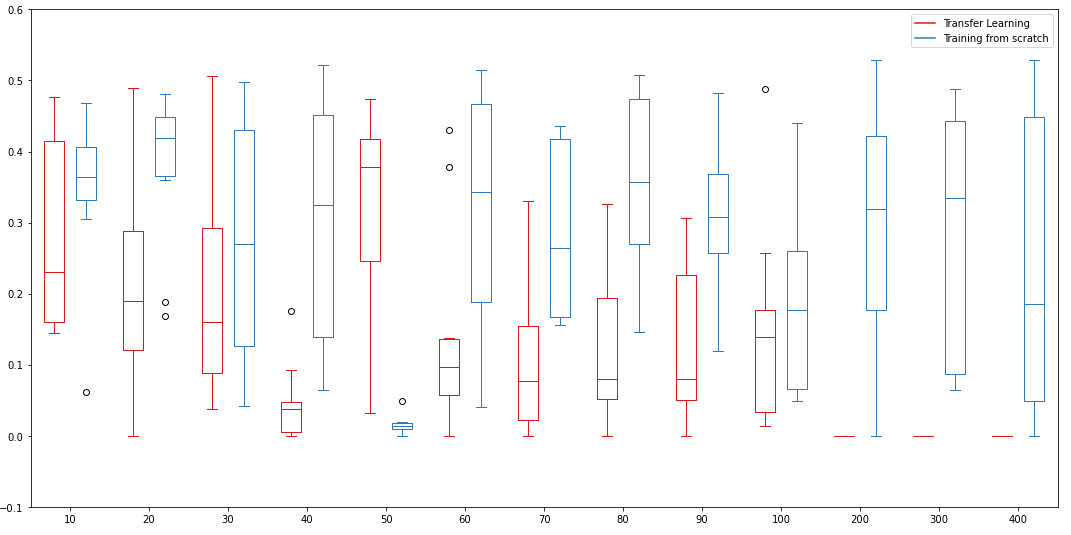

### Possible cause of the performance issue:

1. The data of Covington area is significantly different from Rowan area. The differences in data lead to negative transfer.
    - Gui, L., Xu, R., Lu, Q. et al. Negative transfer detection in transductive transfer learning. Int. J. Mach. Learn. & Cyber. 9, 185–197 (2018). https://doi.org/10.1007/s13042-016-0634-8
    - Ge, L., Gao, J., Ngo, H., Li, K. and Zhang, A. (2014), On handling negative transfer and imbalanced distributions in multiple source transfer learning. Statistical Analy Data Mining, 7: 254-271. https://doi.org/10.1002/sam.11217

**Possible Experiments:** Test the hypoithesis of negative transfer with the area closer to Rowan area OR using Alaska watershades for the study areas. 

2. For the performance issue in training from scratch models, may be caused by the insufficient training data. In the original model by Zewei, the model was trained on 1400 patches (after data augmentatio)'



# Progress 2/8/2021
**Progress:**  
- Start experimenting with small sample size. 
- 10 sample 



# Progress 1/25/2021
**Progress:**  
- Finished the Testing and the results are as follows:

**Note:**  
1. The fine-tuning results look very good but there is the problem at the edge of the stuudy area which if we could fix F-1 score could be higher than training from scratch. 
2. The transfer lerning without fine-tuning still performs poorly as we can see a lot of noise in the prediction map 
3. Still the F1 scores are very low across all methods. 
    - This could be the effect of differences in the data of the source domain (1m resolution, less mountainous area) and target domain ( 5m resolution, moutainous area) 
    - This could be confrimed by the trainging from scratch will always perform better than transfere learning method (with or without finee-tuning)

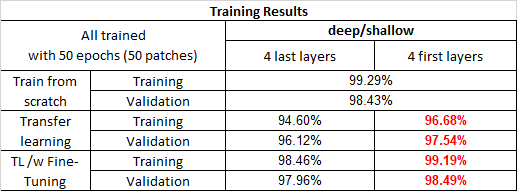

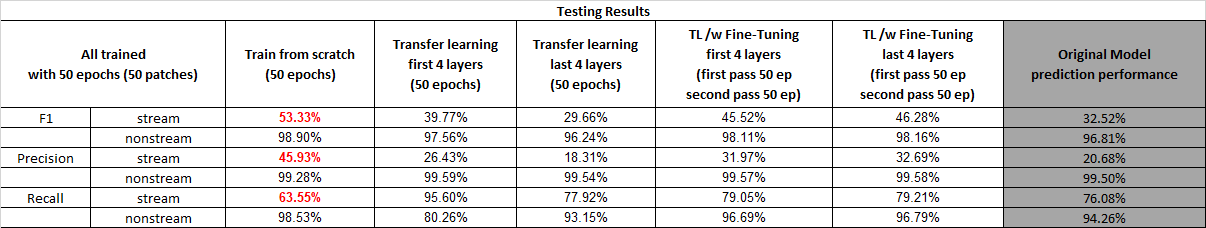

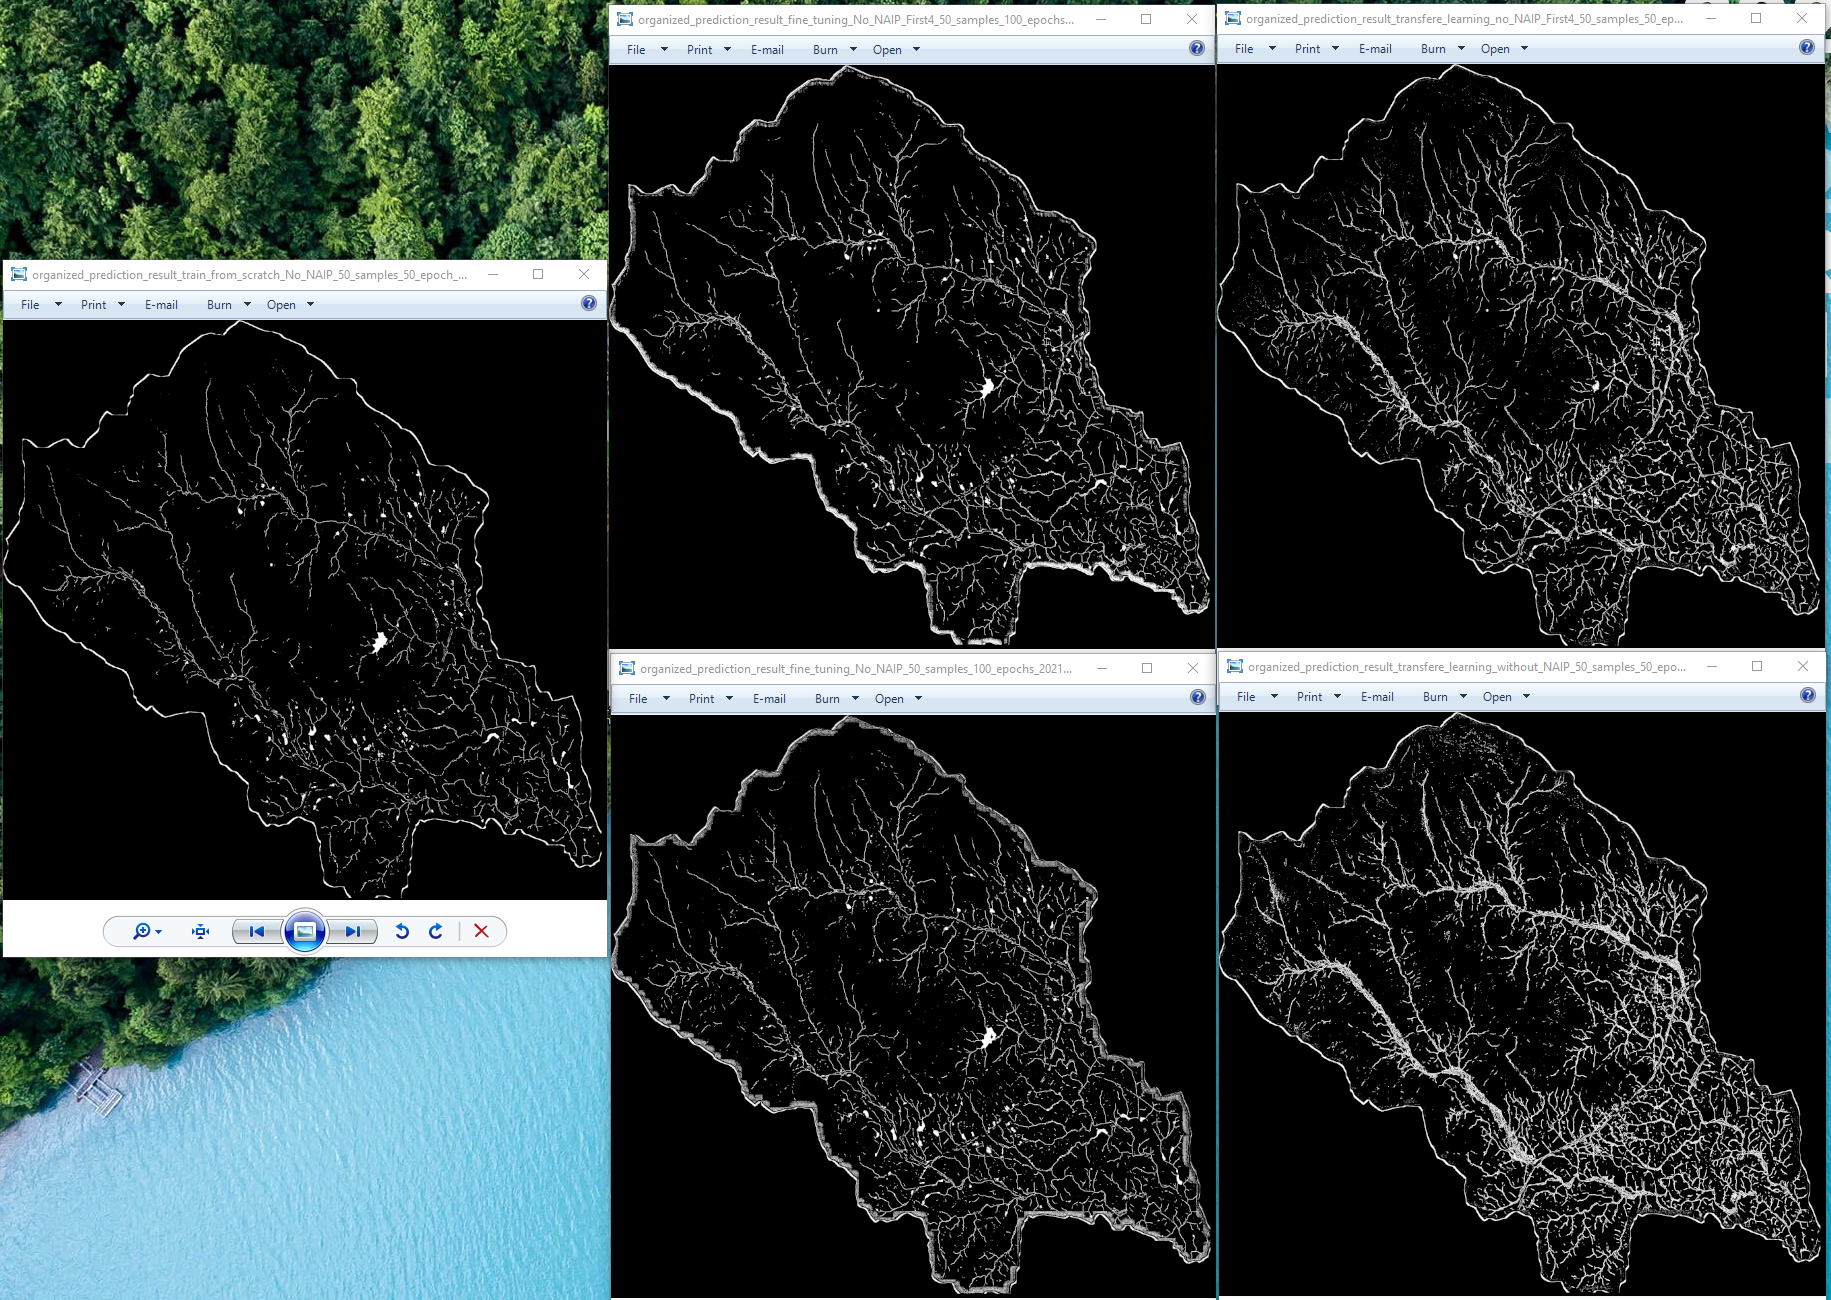

**Plan:**
- Find the root cause of the edge effect. 


<hr>

# Progress 12/21/2020

**Progress**  

- Found 2 interesting papers about how to train U-net model in transfer learning

### [Fine Tuning U-Net for Ultrasound Image Segmentation: Which Layers?](https://link.springer.com/chapter/10.1007/978-3-030-33391-1_27)

Usually the shallow layers are kept unchanged in fine-tuning techniques. Only the deeper layers are modified to fit the target data. They found that with the wit the ultrasound images segmentationm, fine-tuniogn the shallow layers outperformed the fine-tuning the deeper layers when a small amount of images are available. 

### [First U-Net Layers Contain More Domain Specific Information Than the Last Ones](https://link.springer.com/chapter/10.1007/978-3-030-60548-3_12)

This paper claims that fine-tuning the **first layers is superior to fine-tuning the whole network** especially in the case that the sample size is small. 

**Note:** These paper mentioned that becasue the features that they are segmenting are mostly low level feature and the low-level feature associates with shallow layers more than the deep layer. Therefore, fine-tuning shallow layers outperform training the deep layer or evne training the whole network. 

- Ran experiment on the small sample size 
    - Sample size:  50 samples (40 training / 10 validation) 
    - Learning rate: 0.0001
    - Epochs: 50 Epochs   
        **Results:**   
        Training Accuracy: 95.23%  
        Validation Accuracy: 95.77%
      
**Plan:**
- Run the experiments on small sample and small epochs to answer "When will the Transfer Leraning be useful?"
- Try training the shallow layers. 


---




# Progress 11/23/2020
**Progress:**
- Ran more experiments on No-NAIP dataset

<table>
    <tr>
        <td>

### **The results without NAIP dataset**  
            
**trained for 200 epochs**  

Prediction Reults   

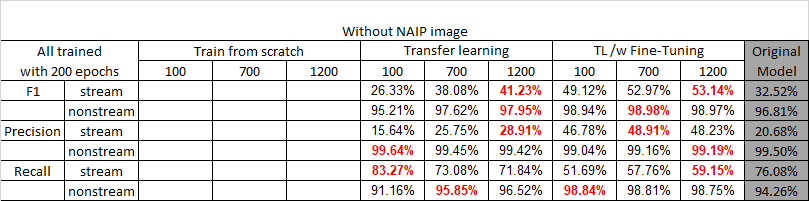

Training Results   

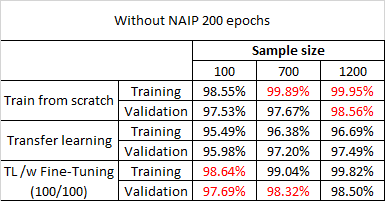

Training Time

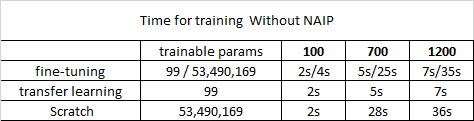
        </td>
        <td>
            
### **The results with NAIP dataset** 
            
**trained for 400 epochs**  

Prediction Reults   

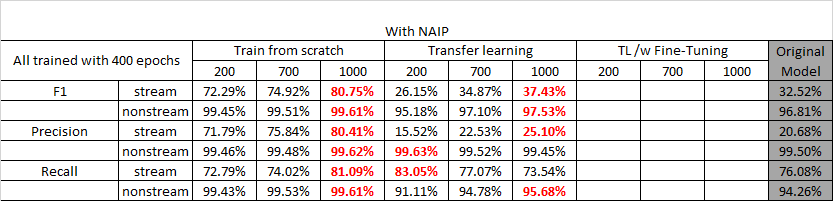

Training Results   

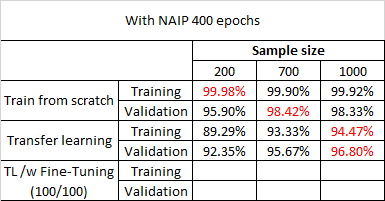

Training Time

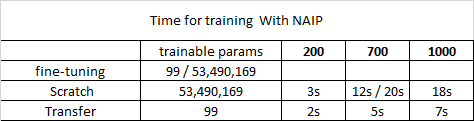
        </td>
    </tr>
    </table>
    
**Plan:**

- finsihed training from scractch for "**without NAIP**" case
- finsihed fine-tuning for "**with NAIP**" case
    
<br>

----

# Progress 11/23/2020
**Progress:**
- Ran more experiments on No-NAIP dataset

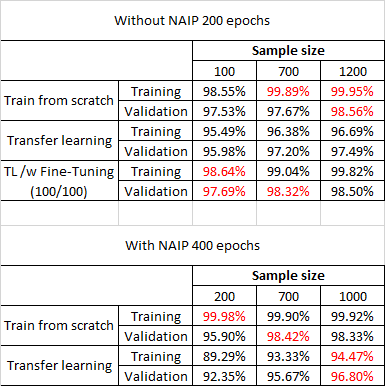


- Evaluate the fine-tuning with No-NAIP dataset, the results are as follows:

**Without NAIP**  

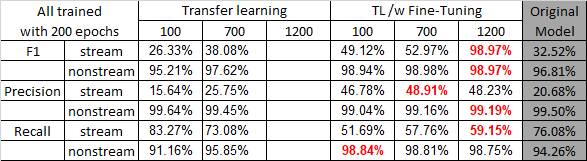

**With NAIP**  

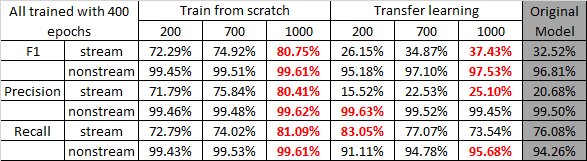

As you can see, the model with fine-tuning performs significantly better than the Transfer Learning without fine-tuning. However, the model tends to underpredict the stream pixel as resulted in lower Recall. 

**Prediction results**

Fine-tuning without NAIP (100 samples):   
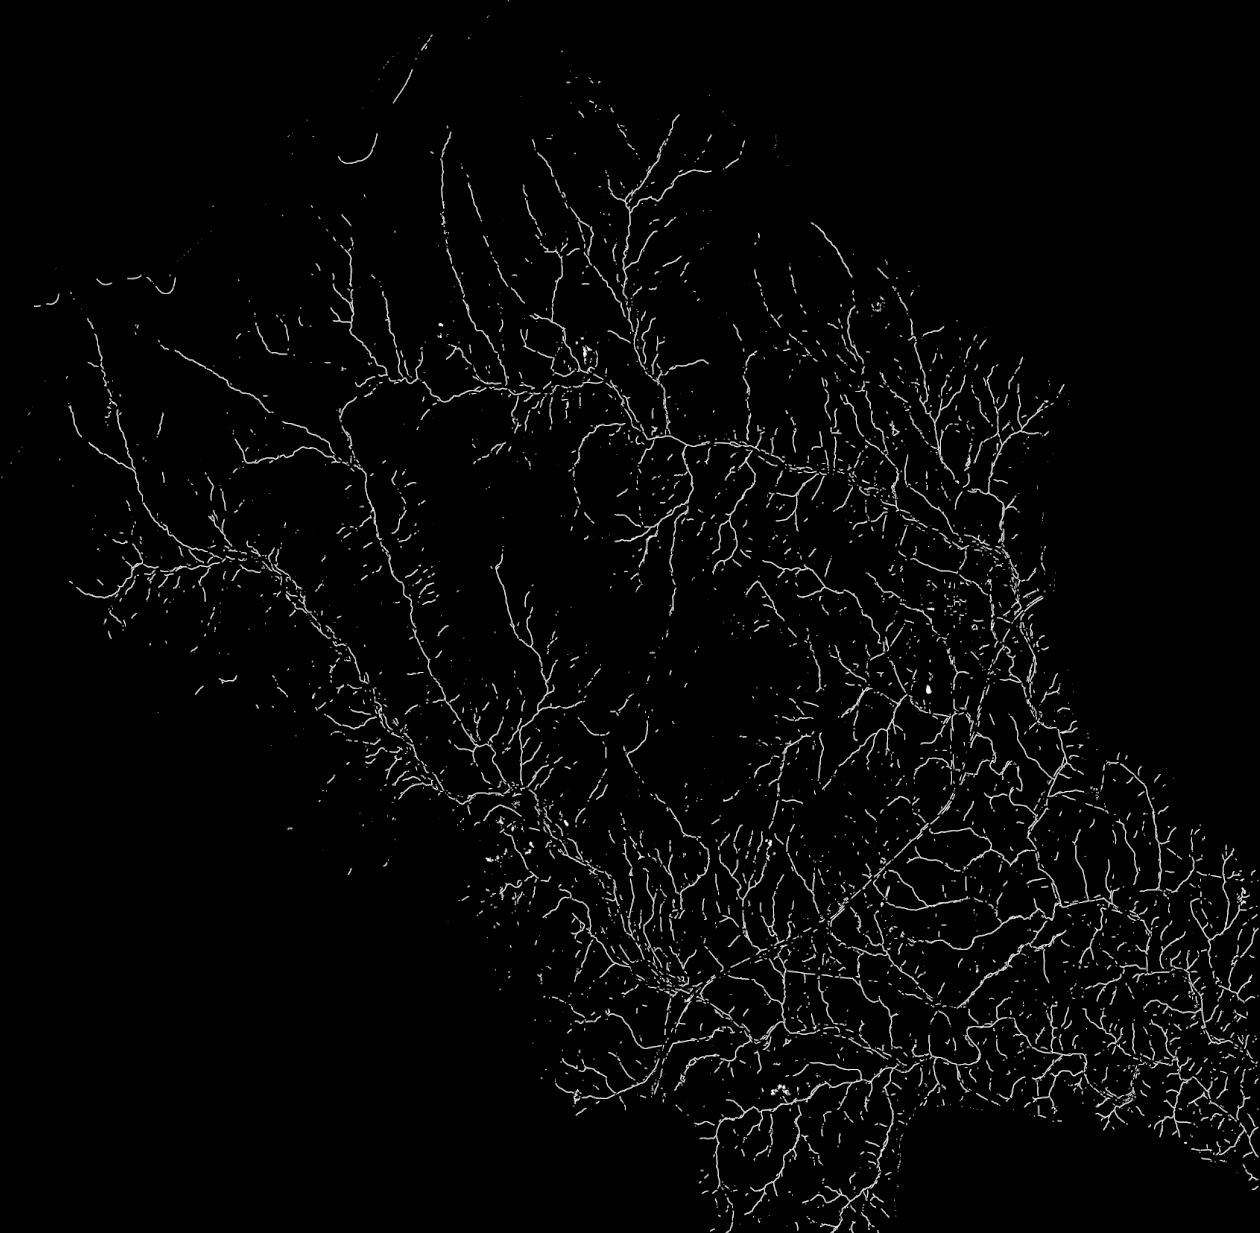

Transfer Learning with NAIP (200 samples):   
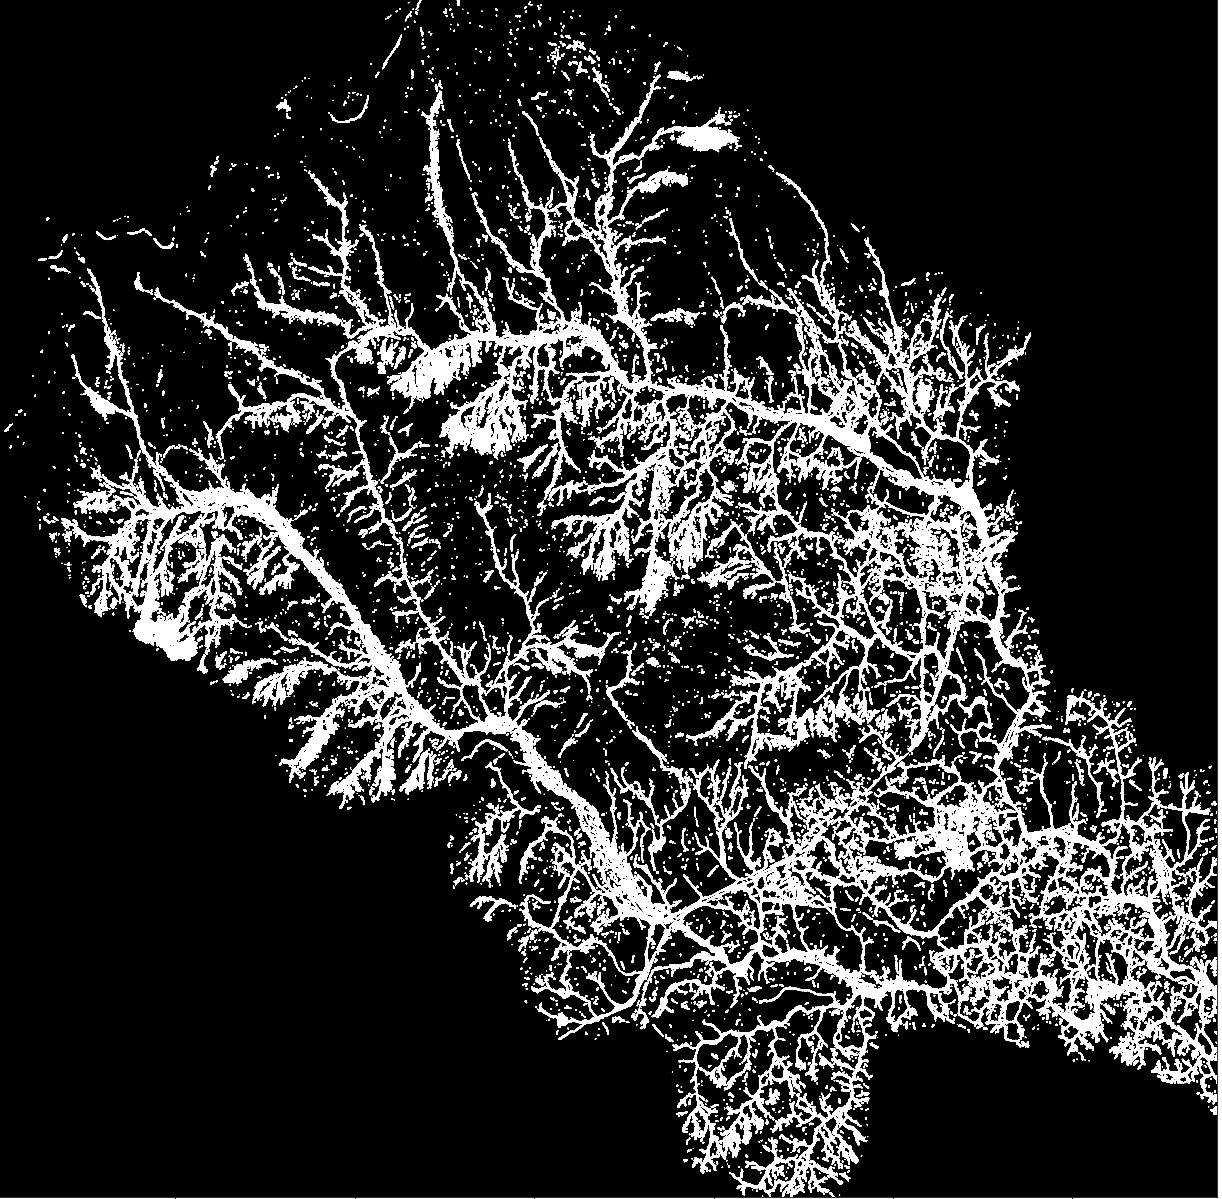


**Plan:**

- Test the training from scratch model. 

# Progress 11/16/2020
**Progress:**
- Generated datasets without NAIP data 
- Performed fine-tuning experiment with

    - 1200 samples (600 training / 600 validation)
    - 700 (350 training / 350 validation) 
    - 100 (50 training / 50 validation)

**First pass:**

- feature extraction 100 epochs 
- learning rate: 0.0001

**Second pass:** 

- fine-tuning 100 epochs
- learning rate: 0.0000359

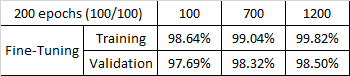



**Training time per epoch (first pass and second pass):** 

- 100 samples : 2s and 4s
- 700 samples : 11s and 34s 
- 1200 samples:  30s and 55s


The first pass, we use the U-net model as the feature extraction and freeze the model except the last 4 layers. Then, we add classifier on top of the model. First pass **stops at 100 epochs** and the **training accuracy is about 90% and validation accuracy is about 87%**.

The second pass, we unfreeze all layers in the model. Second pass converge very quickly. The model starts with very high accuracy ( 90% training accuracy and 70% validation accuracy). Then, it hit the **early stop at around 30 epochs** with very high accuracy ( **98%++ training accuracy and 97% validation accuracy**)


**Plan:**

- Evaluate the models with test data set


---


# Progress 11/09/2020

[Computer Vision and Deep Learning Techniques for the Analysis of Drone-Acquired Forest Images, a Transfer Learning Study]("https://drive.google.com/file/d/1wLuFUSZju8TZdGNygK6eLZAWdoB2yz-t/view?usp=sharing")

- The autor used Deep learning to analyse forest images 
    - compare random intialised, general purpose model, and closely related dataset

**Conslusion:**
- Transfer learning is better than random initialised model. (9.78% improvemnet of Total Agreement)
- Better results were obtained when a more closely related dataset was used
<br>

[Convolutional Neural Network for Remote-Sensing Scene Classification: Transfer Learning Analysis]("https://drive.google.com/file/d/1z9mCQv49hYq12IwxOrTrCCfEjXPIGEQ8/view?usp=sharing")

Evaluate the transfer learning using VGG19 and Icention V3 

1. split the model into shallow, intermediate and deep 
2. test different optimizations 
3. Use the optimization in 2 to test 3 scenarios (100 epochs):
    - feature extraction
    - fine tuning
    - train from scratch 
    
**Conclusion:**
- Fine tuning is powerful for remote sensing
- transfer learning can be done using the genbral purpose model (Natural images: ImageNet)
- The bigger the model the more prone to overfitting 
- if have enough data randomly initialise is also appropriate

[Pavement Crack Detection Using Attention U-Net with Multiple Sources]("https://drive.google.com/file/d/1ruISLbf_AlW222rycJ-TfRATkxHE0mnk/view?usp=sharing")

Propose adding attention module to U-net model and user results from 3 model to detect the crack (only about 200 images of pavement dataset)
Trained 3 Unet models with Dam, Bridge, and Wall dataset 

**Conclusion:**
- Attention improve 1.74%
- transfer learning with Dam, Bridge, and Wall dataset improved around 5%
- Proposed method (fusion model) improved 8%


[Evaluation of Transfer Learning to detect existence of road]("https://drive.google.com/file/d/1v7NLBX6XxICUCJyht0Di8Ir0MjMes0D2/view?usp=sharing")

Test 4 models, VGGNet, Inception-V3, Xception, and Inception-ResNet using 3 methods:
- train from scratch 
- feature extraction
- fine tuning 

**Conclusion:**
- Building from scratch is better 
- Tranfer learning is powerful but need strong regularization to prevent overfitting
- Fine tunig lower layer leads to worse performance and tend to overfit
- featuere extraction: 
    - poorer but less expensive compare to fine tuning 
    - only change hte classifier is not enough espacially when the target and source domains are different
- the more parameter the easier to overfit

<br>

------------


# Progress 11/02/2020 

**Roadblock:** The Conda environment did not work just fixed it today.


**Update:**

1. Attended the "Fundamentals of Accelerated Computing with CUDA C/C++" Course from Nvidia. 
Learned the paradigm of CUDA programming. 
- How to parallize the loop in CUDA to utilize the GPU threads and blocks features. 
- Managing Accelerated Application Memory with CUDA Unified Memory and nsys.
- Asynchronous Streaming, and Visual Profiling for Accelerated Applications with CUDA. 

2. Running more experiments to compare the effect of number of epochs  
Runnning 100 and 800 epochs 

**Plan:**

As discussed with Li last week, I will be debuging the transfer learning model by use the model to predict the validation dataset and evaluate the performance.   
Then compare it to the performance during the trainging process as follows: 

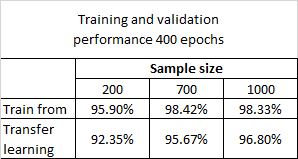

More experiments to answer following questions: 

**Does the number of impage per class in the dataset influence the accuracy?**  
Now the number of patches per class are equal. We should try varying the imbalance samples between stream and nonstream 

**To answer how the data effect the preformance of transfer leanring?**   
We need to choose different combination of these data as the input dataset.        

- Curvature, Slope, Openness, DEM, TPI 21, Reflectance (LiDAR intensity), Geomorphon, TPI 9, TPI 3, channels in NAIP dataset (Red Green, Blue nad NIR). 

**Discussion:**

So far the contribution of transfer learning are:   

1. the training time that is significantly diffrent    
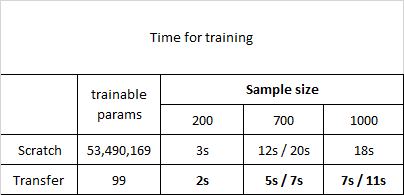

2. The prediction performance compare to the original model   
  
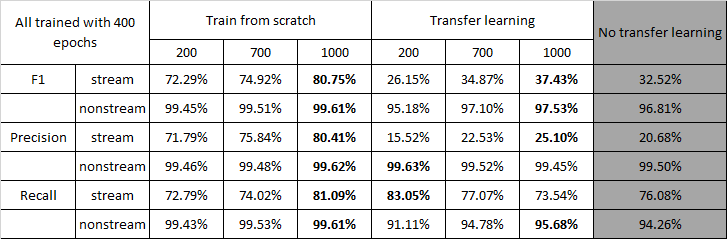

<br>
<br>

----

# Progreess 10/26/2020

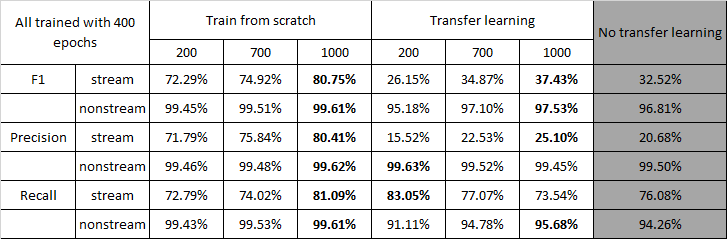


**Note:** 
- Train from scratch model reachg the early stop at around 300 epochs (200 samples), 140 epochs (700 samples), and, 120 epochs (1000 samples).
- Transfer learning model never reach early stop and be trained until 400 epochs regardless.

**What transfer learning contributed to the improvement compare to the barebone model?**

We can say that the number of samples has significant impact on the transfer learning performance. As we can see that the F1 score and the Precision increase with more samples.

However, the Recall of transfer learning is decreased with bigger sample size. This is because the model with more sample produces less stream pixels.


**Question left to answer:**   

**1. Why the transfer learning is worse than the model train from scratch?** 

- number of trainable parameters?, number and position of trainable layer in the models?, different input dataset? 



### **Idea:** 

**To answer how the epoch effect the transfer learning performance?**    
We will vary the epoches numbers 100, 400, and, 800 across the 3 samples sizes  200 700 1000   
<br>

**Does the number of impage per class in the dataset influence the accuracy?**  
Now the number of patches per class are equal. We should try varying the imbalance samples between stream and nonstream 

<br>

**To answer how the data effect the preformance of transfer leanring?**   
We need to choose different combination of these data as the input dataset.        

1. Curvature    
2. Slope  
3. Openness     
4. DEM  
5. TPI 21  
6. Reflectance (LiDAR intensity)  
7. Geomorphon  
8. TPI 9  
9. TPI 3    
10-13.  channels in NAIP dataset, Red Green, Blue nad NIR. 


<br> 

# Progreess 10/19/2020
I am working on the experiments and evaluations.

Evaluated the models with the testing dataset:
200 sample (100 each)  
**Transfer learning model:**  
F1 score of Nonstream: 0.9517416519072421  
F1 score of Stream: 0.26159794325524943  
Precision of Nonstream: 0.9961674084488366  
Precision of Stream: 0.1552479321784964  
Recall of Nonstream: 0.9111092084695467  
Recall of Stream: 0.8305575950360229  

**Training from scratch:**  
F1 score of Nonstream: 0.9944264375286479  
F1 score of Stream: 0.7229422644379787  
Precision of Nonstream: 0.9944767101080924  
Precision of Stream: 0.717981872678855  
Recall of Nonstream: 0.9943761700316845  
Recall of Stream: 0.7279716737149821  

Working on 700 and 1000 samples

### Training from scratch   
- Total params: 53,508,217  
- **Trainable params: 53,490,169**  
- Non-trainable params: 18,048  

**1. Traing the model from scratch without NAIP**   
        
**Without NAIP**  
The training takes **17 seconds** for each epoch  
- First training: the training stop at Epoch 105 (history_train_from_scratch_NoNAIP_20201012-111316)
- We continue for 33 epochs more (history_train_from_scratch_NoNAIP_20201012-112416)
    - Training set accu: 99.92%
    - Validation set accu: 98.52%     

**last line of log**   
Epoch 33/400  
50/50 [==============================] - 16s 313ms/step - loss: -0.9859 - dice_coef: 0.9859 - accuracy: 0.9992 - val_loss: -0.5574 - val_dice_coef: 0.5574 - val_accuracy: 0.9852

**2. Traing the model from scratch with NAIP**   

**With NAIP**   
The training takes **17 seconds** for each epoch 
- First training: the training stop at Epoch 141 (history_train_from_scratch_NAIP_20201012-121601)
    - Training set accu: 99.91%
    - Validation set accu: 98.87%   

**last line of log**     
Epoch 141/400   
50/50 [==============================] - 16s 321ms/step - loss: -0.9849 - dice_coef: 0.9849 - accuracy: 0.9991 - val_loss: -0.6443 - val_dice_coef: 0.6443 - val_accuracy: 0.9887   

<br>

---


> Compare the transfer model with the original model using to predict the targeted area.  
>- Train the original model from scratch.   
>- Then compare to the with transfer learning.   
> Doesn’t have to beat the original but Why?  

### Training from scratch with NAIP vary samples sizes

- Total params: 53,508,217  
- **Trainable params: 53,490,169**  
- Non-trainable params: 18,048 

### **200 samples** (history_train_from_scratch_NAIP_100_samples_20201012-174105)  
+ Training 3 seconds per epoch  
+ Training 80 each class / Validation 20 each class   

    - Training set accu: 99.98%
    - Validation set accu: 95.90%   
    
**last line of log**
Epoch 313/400   
14/14 [==============================] - 3s 244ms/step - loss: -0.9809 - dice_coef: 0.9806 - accuracy: 0.9998 - val_loss: -0.7309 - val_dice_coef: 0.7122 - val_accuracy: 0.9887  

  
   
### **700 samples** (history_transfere-_learning_NAIP_350_samples_20201012-155935)  
+ Training 12 seconds per epoch  
+ Training 262 each class / Validation 88 each class

    - Training set accu: 99.90%
    - Validation set accu: 98.42%   
    
**last line of log**   
Epoch 146/400  
44/44 [==============================] - 12s 266ms/step - loss: -0.9819 - dice_coef: 0.9820 - accuracy: 0.9990 - val_loss: -0.5246 - val_dice_coef: 0.5211 - val_accuracy: 0.9842

  

### **1000 samples** (history_transfere-_learning_NAIP_500_samples_20201012-170026)
+ Training 18 seconds per epoch  
+ Training 375 each class / Validation 125 each class   

    - Training set accu: 99.92%
    - Validation set accu: 98.33%   
    
**last line of log**  
Epoch 139/400  
44/44 [==============================] - 18s 413ms/step - loss: -0.9241 - dice_coef: 0.9241 - accuracy: 0.9992 - val_loss: -0.4393 - val_dice_coef: 0.4326 - val_accuracy: 0.9833  


  
---

## Transfer learning 
  
> Try to show what transfer learning contributed to the improvement compare to the barebone model.  
> What are the parameters or steps that contributed to the improvement.   
> - Sample sizes (200, 700, 1000)
> - Different layers (With and without NAIP)   


- Total params: 53,508,219  
- **Trainable params: 99**  
- Non-trainable params: 53,508,120  

## **1. Generate different samples size** 

### **200 samples** (history_transfere-_learning_NAIP_100_samples_20201012-150904)  
+ Training 2 seconds per epoch  
+ Training 80 each class / Validation 20 each class   

    - Training set accu: 89.29%
    - Validation set accu: 92.35%   

**last line of log**  
Epoch 400/400  
14/14 [==============================] - 2s 152ms/step - loss: -0.1299 - dice_coef: 0.1286 - accuracy: 0.8929 - val_loss: -0.0814 - val_dice_coef: 0.0933 - val_accuracy: 0.9235  



### **700 samples** (history_transfere-_learning_NAIP_350_samples_20201012-155935)  
+ Training 5 seconds per epoch  
+ Training 262 each class / Validation 88 each class  
    - Training set accu: 93.33%
    - Validation set accu: 95.67%   

**last line of log**  
Epoch 400/400   
44/44 [==============================] - 5s 112ms/step - loss: -0.2160 - dice_coef: 0.2159 - accuracy: 0.9333 - val_loss: -0.1523 - val_dice_coef: 0.1507 - val_accuracy: 0.9567    



### **1000 samples** (history_transfere-_learning_NAIP_500_samples_20201012-170026)
+ Training 7 seconds per epoch  
+ Training 375 each class / Validation 125 each class
    - Training set accu: 94.47%
    - Validation set accu: 96.80%   

**last line of log**  
Epoch 400/400  
63/63 [==============================] - 12s 186ms/step - loss: -0.2798 - dice_coef: 0.2807 - accuracy: 0.9447 - val_loss: -0.1829 - val_dice_coef: 0.1831 - val_accuracy: 0.9680  0.9447


<br>
<br>

  
---- 

# Progress 28/09/2020    

Established the baseline for **400 epochs**  
                                                 
Base line Model (Transfer learnign with NAIP data) can achieve validation acc. **92.89%**

1. Added SpatialDropout2D layer    
    **Result:** The dropout doesn't help in this case.     
    with 0.3 drop rate and 400 epochs we can achieve validation acc. 92.63%   
    with 0.5 drop rate and 400 epochs we can achieve validation acc. 92.32%  
    with 0.7 drop rate and 400 epochs we can achieve validation acc. 92.06%   
    
    Compare to Dropout layer   
    with 0.3 drop rate and 400 epochs we can achieve validation acc. 92.56%  
    with 0.5 drop rate and 400 epochs we can achieve validation acc. 92.34%  
    with 0.7 drop rate and 400 epochs we can achieve validation acc. 92.22%%  
    
2. Fine-tuning doesn't help much  
    first pass learning rate 0.0001   
    second pass learning rate 0.00001   
    **Result:** we can achieve validation acc. 92.48%   
   
3. Woking on classifier after the convolutional network

# Plan work
1. Create colab notebook for RIF meeting 
2. Continue writing

---

# Progress 28/09/2020
1. Added Dropout layer    
    **Result:** The dropout doesn't help in this case.   
    with 0.3 drop rate and 400 epochs we can achive 92.56%  
    with 0.5 drop rate and 1000 epochs we can achive 94.1%  
    with 0.7 drop rate and 400 epochs we can achive 92.2%  
    
2. Working on Fine-tuning process 
3. Working on Literature review


# Plan work

1. Finsihing the Literature review 
2. Try adding classifier after the convolutional network
3. Begin the intro and abstract

---

# Progress 21/09/2020
1. Genreating the result for transfer learnign without NAIP again 
2. Created the [plan until Mid Oct 2020]("https://docs.google.com/document/d/1Kqz18zgB-DSkDarr-m8Y-__0ZCNzXAkTZw7Xg7kIy08/edit#")
    - The goal is to finish the first draft by Mid Oct. 
    
# Plan work
1. Start writing the paper
2. Try training the model with more weight of stream class.
3. Weekly plan until Mid October 2020[.]('https://analyticsindiamag.com/top-10-papers-on-transfer-learning-one-must-read-in-2020/')  

--- 

# Progress 14/09/2020
1. Read and summarize more  [transfer learning paper]('https://openreview.net/pdf?id=ryxyCeHtPB')  
    - propose "attentive feature distillation and selection (AFDS)"   
    - AFDS dynamically learns not only the features to transfer, but also the unimportant neurons to skip    
    

# Plan work
1. Start writing the paper
2. Try training the model with more weight of stream class.
3. Weekly plan until Mid October 2020

**Qual Exam beginning of next semester**

---

# Progress 07/09/2020  
1. Presented the progress in CEGIS  
  
2. Generated total dataset for Covingtoin area (without NAIP imagery)
    
3. Run prediction of the Convington area with the dataset without NAIP and using the original model that is trained on Rowan creek area  


# Plan work
1. Try training the model with more weight of stream class.

---

# Progress 31/08/2020
1. Corrected the data (removing None class (-9999) from test dataset)
    - will generate the new test results  
  
  
2. Preparing for CEGIS presentation
    - Added prelim results  
    - Will add the base scenario which is the U-net model predict the dataset without NAIP in Covinton river  
      
        
    
3. preparing the script for the presentation  
    
# Plan for this week
1. Finish the presentation for CEGIS
2. Read and summarize more paper
3. Try training the model with more weight of stream class.

----

# Progress 24/08/2020

**Comments:** Try to get the why and what it hold true and how to make or to apply to other places.  

1. Generate the whole area and do testing
    - Generated the dataset
    - Evaluated the testing data and generated the prelim results
**Problem:** the data has more than 2 classes as shown in evaluation.   
      
    
2. Created the outline of the presentation for CEGIS 
    - Still need more details:   
    https://docs.google.com/presentation/d/1PWrlgGEMCCJLXsAHeiTe40xdA22RtISE6gUpRbbplRs/edit?usp=sharing

# Plan for this week
1. Finish the presentation for CEGIS
2. Read and summarize more paper
3. Try training the model with more weight of stream class.
4. Correct the data (remove the None class)

---

# Progress 17/08/2020
1. Finished generating the new dataset
    - Cleaned the NAIP data and all raw data of Covington River
    - Included NAIP imagery into the dataset
    - Edited the data preprocessing script to make it easier to add or remove data 
    - Added script documents and comments  
      
2. Generating the whole area dataset the included NAIP imagery
    - Using High memory node on Keeling   
    - **Problem:** The VPN disconnected after 2 hours in!!! T_T I have to start over.  
  
3. Trained the model with new dataset  
    - The performance is significatly higher than the dataset without NAIP  
  
4. Read more papers and added summary of the read paper
    -https://docs.google.com/document/d/1BApPn0aWTwstEpbnKC9g0p5KSOhi74_rF7nzRYM9CtE/edit  
  
# Plan for this week
1. Generate the whole area and do testing
2. Start preparing the presentation for CEGIS 
3. Read and summarize more papers
    - Focus more on machine learning in hydro, remote sensing classification.



---



# Prgress 10/08/2020

1. Successfully trained the model on my own PC.  
    - Fixed cuCNN and CUDA version problems 
    - Trained with 4 trainable layers  
      **Problem:** The model just disrtegards the stream class.  
      **Root cause:** Unbalanced sample of stream and non-stream classes   

2. In progress: Adding NAIP image to the dataset. 
    - Extracted the NAIP for Covinton and put it on Keeling 
    - modifying the preprocessing code
    
3. Outline the Introduction of the paper and reviewed some papers
    - https://docs.google.com/document/d/1BApPn0aWTwstEpbnKC9g0p5KSOhi74_rF7nzRYM9CtE/edit
    
# Plan for this week
1. Finished adding the NAIP and train the model again
2. Start the first draft of the introduction 

